In [1]:
import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import numpy as np
import pickle
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from testing import Tester
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib

In [2]:
QUESTION = "How much does this cost to the nearest dollar?\n\n"
DB = "products_vectorstore"

In [3]:
with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [4]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [5]:
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
prices = [metadata['price'] for metadata in result['metadatas']]

In [6]:
load_dotenv(override=True)
api_key = os.getenv("GROQ_API_KEY")

In [7]:
from groq import Groq

groq_client = Groq(api_key=api_key)

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(vectors, prices)

In [ ]:
joblib.dump(rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [10]:
rf_model = joblib.load('random_forest_model.pkl')

In [11]:
from agents.specialist_agent import SpecialistAgent
from agents.frontier_agent import FrontierAgent
from agents.random_forest_agent import RandomForestAgent

In [12]:
specialist = SpecialistAgent()
frontier = FrontierAgent(collection)
random_forest = RandomForestAgent()

In [13]:
def description(item):
    return item.prompt.split("to the nearest dollar?\n\n")[1].split("\n\nPrice is $")[0]

In [14]:
def rf(item):
    return random_forest.price(description(item))

1: Guess: $293.32 Truth: $374.41 Error: $81.09 SLE: 0.06 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $197.98 Truth: $225.11 Error: $27.13 SLE: 0.02 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $230.41 Truth: $61.68 Error: $168.73 SLE: 1.71 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $318.29 Truth: $599.99 Error: $281.70 SLE: 0.40 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $236.19 Truth: $16.99 Error: $219.20 SLE: 6.65 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $84.14 Truth: $31.99 Error: $52.15 SLE: 0.90 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $242.63 Truth: $101.79 Error: $140.84 SLE: 0.74 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $218.71 Truth: $289.00 Error: $70.29 SLE: 0.08 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $323.79 Truth: $635.86 Error: $312.07 SLE: 0.45 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $176.44 Truth: $65.99 Error: $110.45 SLE

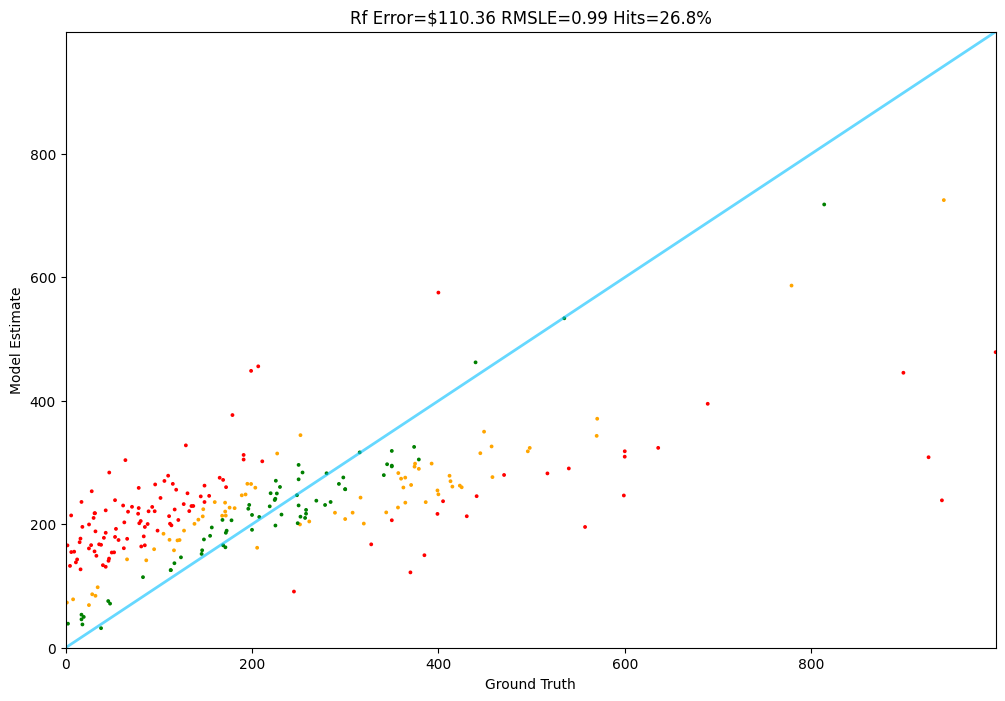

In [15]:
Tester.test(rf, test)

In [16]:
product = "Quadcast HyperX condenser mic for high quality audio for podcasting"

In [17]:
print(specialist.price(product))
print(frontier.price(product))
print(random_forest.price(product))

189.0
140.0
243.43250000000026


In [18]:
specialists = []
frontiers = []
random_forests = []
prices = []
for item in tqdm(test[1000:1250]):
    text = description(item)
    specialists.append(specialist.price(text))
    frontiers.append(frontier.price(text))
    random_forests.append(random_forest.price(text))
    prices.append(item.price)

100%|██████████| 250/250 [11:42<00:00,  2.81s/it]


In [19]:
mins = [min(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]
maxes = [max(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]

X = pd.DataFrame({
    'Specialist': specialists,
    'Frontier': frontiers,
    'RandomForest': random_forests,
    'Min': mins,
    'Max': maxes,
})

# Convert y to a Series
y = pd.Series(prices)

In [20]:
np.random.seed(42)

lr = LinearRegression()
lr.fit(X, y)

feature_columns = X.columns.tolist()

for feature, coef in zip(feature_columns, lr.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept={lr.intercept_:.2f}")

Specialist: 0.62
Frontier: 0.20
RandomForest: -0.20
Min: 0.24
Max: 0.12
Intercept=24.89


In [21]:
joblib.dump(lr, 'ensemble_model.pkl')

['ensemble_model.pkl']

In [22]:
from agents.ensemble_agent import EnsembleAgent
ensemble = EnsembleAgent(collection)

In [23]:
ensemble.price(product)

np.float64(185.82798913249079)

In [24]:
def ensemble_pricer(item):
    return max(0,ensemble.price(description(item)))

1: Guess: $408.74 Truth: $374.41 Error: $34.33 SLE: 0.01 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $212.30 Truth: $225.11 Error: $12.81 SLE: 0.00 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $42.46 Truth: $61.68 Error: $19.22 SLE: 0.13 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $400.86 Truth: $599.99 Error: $199.13 SLE: 0.16 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $30.01 Truth: $16.99 Error: $13.02 SLE: 0.30 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $36.17 Truth: $31.99 Error: $4.18 SLE: 0.01 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $124.73 Truth: $101.79 Error: $22.94 SLE: 0.04 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $364.46 Truth: $289.00 Error: $75.46 SLE: 0.05 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $865.47 Truth: $635.86 Error: $229.61 SLE: 0.09 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $70.27 Truth: $65.99 Error: $4.28 SLE: 0.00 It

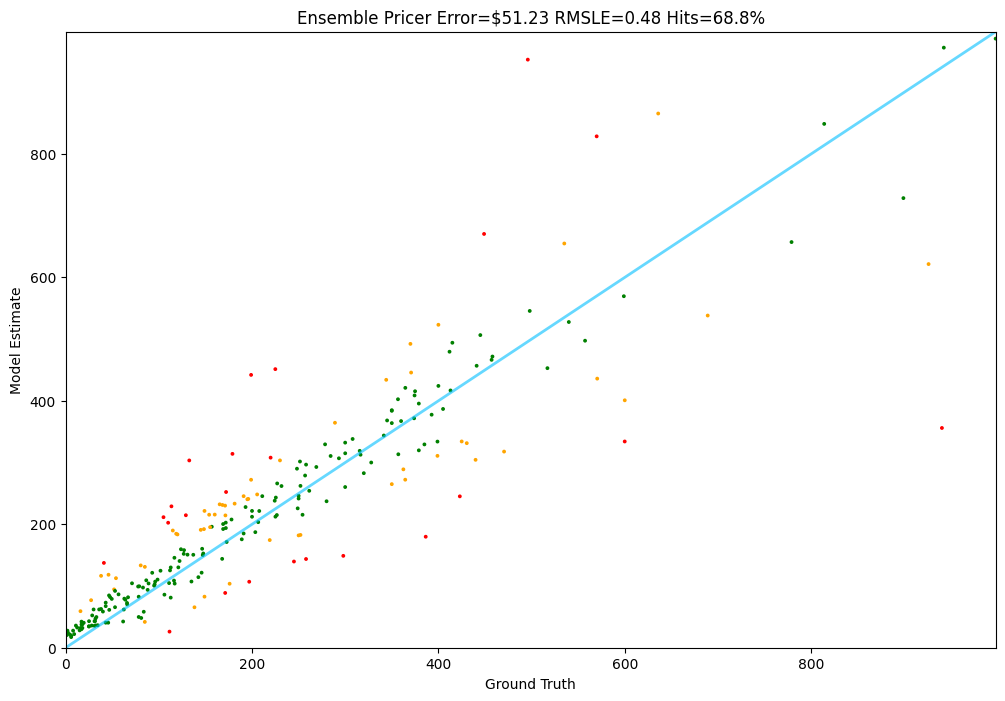

In [26]:
Tester.test(ensemble_pricer, test)